In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

First few rows of the dataset:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A 

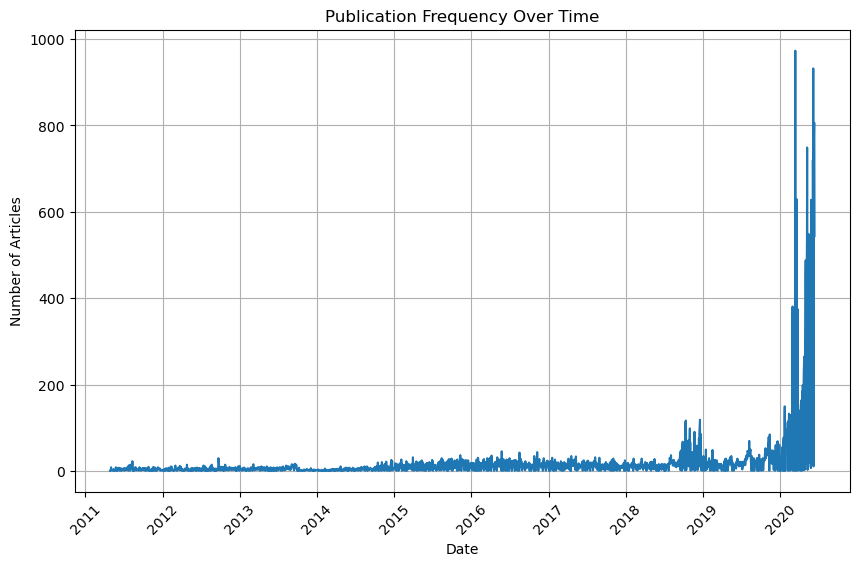

In [2]:
try:
  # Load the dataset
  df = pd.read_csv('../data/raw_analyst_ratings.csv')

  # Display the first few rows of the dataset
  print("First few rows of the dataset:")
  print(df.head())

  # Descriptive Statistics
  # Obtain basic statistics for headline lengths 
  try:
      df['headline_length'] = df['headline'].apply(len)
      headline_stats = df['headline_length'].describe()
      print("\nDescriptive Statistics for Headline Lengths:")
      print(headline_stats)
  except (KeyError, AttributeError) as e:
      print("\nError calculating headline lengths:", e)

  # Count the number of articles per publisher 
  try:
      publisher_counts = df['publisher'].value_counts()
      print("\nNumber of Articles per Publisher:")
      print(publisher_counts.head(10))  # Display top 10 most active publishers
  except KeyError as e:
      print("\nError counting articles per publisher:", e)

  # Analyze the publication dates to see trends over time
  try:
      df['date'] = pd.to_datetime(df['date'], errors='coerce')
      publication_frequency = df.groupby(df['date'].dt.date).size()

      # Plot publication frequency over time
      plt.figure(figsize=(10, 6))
      plt.plot(publication_frequency.index, publication_frequency.values)
      plt.xlabel('Date')
      plt.ylabel('Number of Articles')
      plt.title('Publication Frequency Over Time')
      plt.xticks(rotation=45)
      plt.grid(True)
      plt.show()
  except (KeyError, AttributeError, ValueError) as e:
      print("\nError analyzing publication dates:", e)

except FileNotFoundError as e:
  print("Error: File not found. Please check the file path:", e)

In [14]:
def perform_sentiment_analysis(df):
    """Performs sentiment analysis on headlines using spaCy and VADER.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        pandas.DataFrame: The DataFrame with the added 'sentiment_category' column categorized into positive, negative, or neutral.

    Raises:
        KeyError: If the 'headline' column is not found in the DataFrame.
        ImportError: If spaCy or VADER modules cannot be imported.
    """
    try:
        # Check if 'headline' column exists
        if 'headline' not in df.columns:
            raise KeyError("Column 'headline' not found in the DataFrame")

        # Load the spaCy English model
        nlp = spacy.load('en_core_web_sm')

        # Perform sentiment analysis using spaCy
        df['spacy_sentiment'] = df['headline'].apply(lambda x: get_spacy_sentiment(x, nlp))

        # Perform sentiment analysis using VADER
        analyzer = SentimentIntensityAnalyzer()
        df['vader_sentiment'] = df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

        # Combine sentiment scores from spaCy and VADER
        df['sentiment'] = (df['spacy_sentiment'] + df['vader_sentiment']) / 2

        # Define thresholds for sentiment categories
        neutral_threshold = 0 # Adjust this threshold as needed
        

        # Categorize sentiment into positive, negative, or neutral
        df['sentiment_category'] = df['sentiment'].apply(lambda score: 'positive' if score > neutral_threshold else ('negative' if score < neutral_threshold else 'neutral'))

        # Drop intermediate sentiment columns
        df.drop(['spacy_sentiment', 'vader_sentiment', 'sentiment'], axis=1, inplace=True)

        return df
    except ImportError as e:
        print("Error importing required modules:", e)
        return df  # Return the original DataFrame if module import fails
    except KeyError as e:
        print("Error:", e)
        return df  # Return the original DataFrame if 'headline' column not found

def get_spacy_sentiment(text, nlp):
    """Performs sentiment analysis on a text using spaCy.

    Args:
        text (str): The input text.
        nlp: The spaCy language model.

    Returns:
        float: The sentiment score.
    """
    doc = nlp(text)
    return doc.sentiment
try:
    # Sentiment analysis 
    df1 = pd.read_csv('../data/raw_analyst_ratings.csv', nrows=100)
    df_with_sentiment = perform_sentiment_analysis(df1)
    print(df_with_sentiment[['headline', 'sentiment_category']].head(10))
except FileNotFoundError as e:
  print("Error: File not found. Please check the file path:", e)

                                            headline sentiment_category
0            Stocks That Hit 52-Week Highs On Friday            neutral
1         Stocks That Hit 52-Week Highs On Wednesday            neutral
2                      71 Biggest Movers From Friday            neutral
3       46 Stocks Moving In Friday's Mid-Day Session            neutral
4  B of A Securities Maintains Neutral on Agilent...           positive
5  CFRA Maintains Hold on Agilent Technologies, L...           negative
6  UBS Maintains Neutral on Agilent Technologies,...            neutral
7  Agilent Technologies shares are trading higher...           positive
8  Wells Fargo Maintains Overweight on Agilent Te...           negative
9         10 Biggest Price Target Changes For Friday            neutral


In [17]:
def identify_common_keywords(df):
  """Identifies common keywords for topic modeling using Latent Dirichlet Allocation (LDA).

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.

  Prints:
      Common keywords for each identified topic.
  """
  try:
    vectorizer = CountVectorizer(stop_words='english', lowercase=True)
    df2 = pd.read_csv('../data/raw_analyst_ratings.csv', nrows=10000)
    X = vectorizer.fit_transform(df2['headline'])

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    keywords_per_topic = []
    for topic_idx, topic in enumerate(lda.components_):
        top_keywords_idx = topic.argsort()[:-10 - 1:-1]  # Top 10 keywords
        keywords_per_topic.append([feature_names[i] for i in top_keywords_idx])

    print("\nCommon Keywords for Each Topic:")
    for idx, keywords in enumerate(keywords_per_topic):
        print(f"Topic {idx+1}: {', '.join(keywords)}")
  except (KeyError, ValueError) as e:
    print("Error during topic modeling:", e)

#Topic Modeling
identify_common_keywords(df)


Common Keywords for Each Topic:
Topic 1: earnings, shares, alcoa, trading, says, companies, scheduled, higher, aluminum, american
Topic 2: auto, stocks, parts, results, advance, week, 52, quarter, industry, apple
Topic 3: vs, est, eps, sales, reports, target, price, agilent, technologies, alcoa
Topic 4: buy, announces, pt, alcoa, 00, downgrades, upgrades, abbvie, bank, amerisourcebergen
Topic 5: market, stocks, benzinga, stock, mid, session, moving, day, earnings, watch


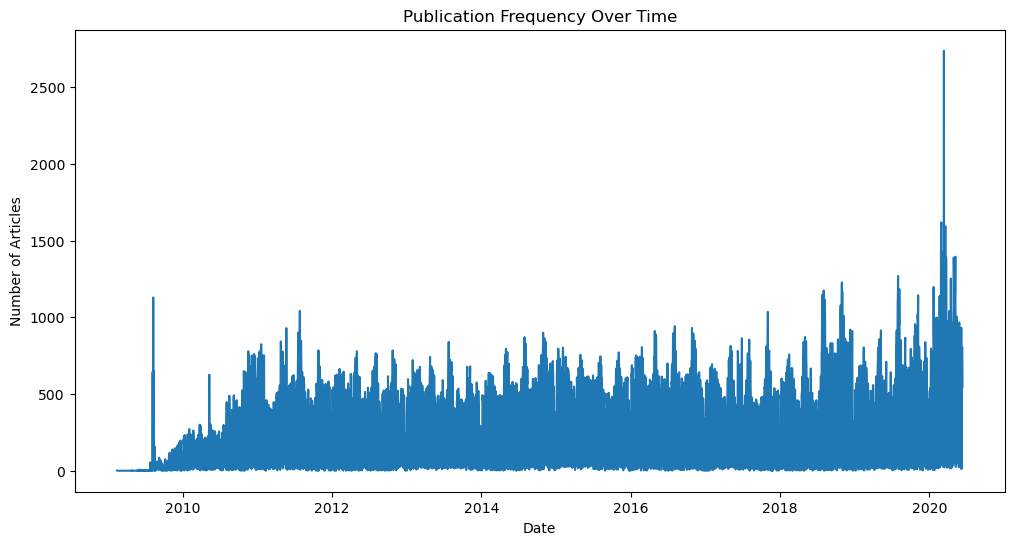

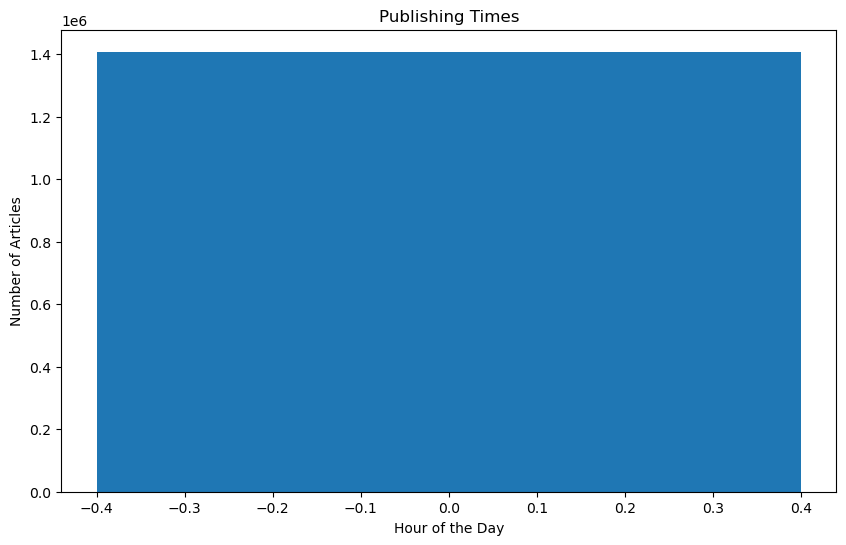

In [21]:
try:
   
    # Convert Date Column
    df['date'] = pd.to_datetime(df['date'].str.split().str[0], format='%Y-%m-%d')
    df.set_index('date', inplace=True)

    # Publication Frequency Analysis
    publication_frequency = df.resample('D').size()  # Resample data daily and count articles

    # Plot Publication Frequency
    plt.figure(figsize=(12, 6))
    plt.plot(publication_frequency.index, publication_frequency.values)
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.title('Publication Frequency Over Time')
    plt.show()

    # Publishing Time Analysis
    df['hour'] = df.index.hour

    # Plot Publishing Times
    publishing_times = df.groupby('hour').size()
    plt.figure(figsize=(10, 6))
    plt.bar(publishing_times.index, publishing_times.values)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Articles')
    plt.title('Publishing Times')
    plt.show()

except FileNotFoundError:
    print("Error: File not found. Please make sure the file exists.")
except KeyError as e:
    print(f"Error: {e}. Make sure the dataset contains the required columns.")


Publisher Contribution Analysis:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Name: count, dtype: int64


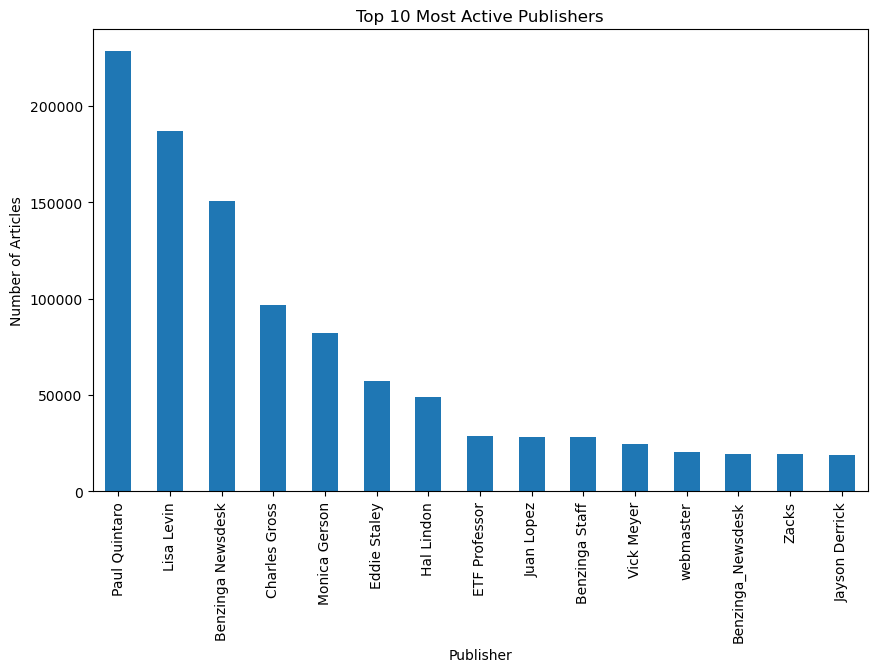

In [25]:
# Publisher Contribution Analysis
publisher_counts = df['publisher'].value_counts()

# Display top 10 most active publishers
print("\nPublisher Contribution Analysis:")
print(publisher_counts.head(15))

# Identify Unique Domains
if '@' in publisher_counts.index[0]:
    unique_domains = [email.split('@')[-1] for email in publisher_counts.index]
    domain_counts = pd.Series(unique_domains).value_counts()

    # Display top 10 unique domains
    print("\nUnique Domains Analysis:")
    print(domain_counts.head(10))

# Step 4: Visualize Results
plt.figure(figsize=(10, 6))
publisher_counts.head(15).plot(kind='bar')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.title('Top 10 Most Active Publishers')
plt.show()